In [1]:
#Democratic Approval of Signal Hierarchy 
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
from statistics import mean
from copy import deepcopy
import pandas_ta

In [2]:
BASE_URL = 'https://paper-api.alpaca.markets'
ALPACA_API_KEY = 'PKH15E01MGRA54FBEYRI'
ALPACA_SECRET_KEY = '4U5Q9fPaNDGp8Krj2lYG5NOxjYqqftYQWAlzmxwe'

api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')


In [3]:
DATA = api.get_bars("SPY", TimeFrame.Day, start = "2020-09-01", adjustment='raw').df
print(DATA)

                             open    high     low   close     volume  \
timestamp                                                              
2020-09-01 04:00:00+00:00  350.24  352.71  349.24  352.60   54999325   
2020-09-02 04:00:00+00:00  354.64  358.75  353.43  357.70   69605495   
2020-09-03 04:00:00+00:00  355.85  356.38  342.59  345.39  150557268   
2020-09-04 04:00:00+00:00  346.07  347.83  334.87  342.57  140821602   
2020-09-08 04:00:00+00:00  336.74  342.64  332.88  333.21  115301649   
...                           ...     ...     ...     ...        ...   
2022-07-27 04:00:00+00:00  394.43  402.88  394.05  401.04   81319074   
2022-07-28 04:00:00+00:00  401.84  406.80  398.15  406.07   73966563   
2022-07-29 04:00:00+00:00  407.70  413.02  406.77  411.99   86779944   
2022-08-01 04:00:00+00:00  409.16  413.41  408.40  410.77   69633616   
2022-08-02 04:00:00+00:00  409.03  413.00  406.82  408.06   63113622   

                           trade_count        vwap  
timestamp 

In [55]:
class Agent:
    def __init__(self, data):
        self.data = data
        
    def execute(self):
        self.data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
        self.data.ta.adx(length = 7, lensig = 7, append=True)
        self.data['cross'] = 0.0
        self.data['cross'] = np.where(self.data['MACD_12_26_9'] > self.data['MACDs_12_26_9'] , 1.0, 0.0)
        self.data['signal'] = self.data['cross'].diff()
        map_dict = {-1.0: 'sell', 1.0: 'buy', 0.0: 'none'}
        self.data['signal'] = self.data['signal'].map(map_dict)
        signal = []
        prev_removed = ''
        for i in range(len(self.data['close'])):
            if self.data['signal'][i] != 'none' and self.data['ADX_7'][i] > 30:
                if self.data['signal'][i] == 'buy' and self.data['DMP_7'][i] < self.data['DMN_7'][i]:
                    signal.append('none')
                    prev_removed = self.data['signal'][i]
                elif self.data['signal'][i] == 'sell' and self.data['DMN_7'][i] < self.data['DMP_7'][i]:
                    signal.append('none')
                    prev_removed = self.data['signal'][i]
                else:
                    signal.append(self.data['signal'][i])
            elif self.data['signal'][i] != 'none' and self.data['ADX_7'][i] < 30:
                signal.append('none')
                prev_removed = self.data['signal'][i]
            else:
                signal.append(self.data['signal'][i])
            
        
        self.data['signal'] = signal
        return self.data
        
    def evaluate(self):
        transaction_type = ['buy', 'sell']
        self.transaction_data = self.data[self.data['signal'].isin(transaction_type)]
        signal = self.transaction_data['signal'].tolist()
        close = self.transaction_data['close'].tolist()
        self.profit = 0.0
        for i in range(1,len(signal)):
            if signal[i-1] == 'buy' and signal[i] == 'sell':
                self.profit = self.profit + (close[i] - close[i-1])
                #print('buy-sell performance: ' + str((close[i] - close[i-1])))
            elif signal[i-1] == 'sell' and signal[i] == 'buy':
                self.profit = self.profit + (close[i-1] - close[i])
                #print('sell-buy performance: ' + str((close[i-1] - close[i])))
        return self.profit
        
    def plot(self, price_only):
        if not price_only:    
            fig, (ax1, ax2, ax3) = plt.subplots(3,figsize = (15,5))
            ax1.plot(self.data['close'], color = 'black')
            ax2.plot(self.data['MACD_12_26_9'])
            ax2.plot(self.data['MACDs_12_26_9'])
            for i in range(len(self.data['close'])):
                if str(self.data['MACDh_12_26_9'][i])[0] == '-':
                    ax2.bar(self.data['close'].index[i], self.data['MACDh_12_26_9'][i], color = '#ef5350')
                else:
                    ax2.bar(self.data['close'].index[i], self.data['MACDh_12_26_9'][i], color = '#26a69a')

            ax3.plot(self.data['ADX_7'], color = 'black')
            ax3.plot(self.data['DMP_7'], color = 'green')
            ax3.plot(self.data['DMN_7'], color = 'red')
            ax2.set_xlim(left=self.data.index[0])
            ax3.set_xlim(left=self.data.index[0])
        else:
            fig, ax1 = plt.subplots(1,figsize = (15,5))
            ax1.plot(self.data['close'])

        ax1.plot(self.data[self.data['signal'] == 'buy'].index,
                     self.data['close'][self.data['signal'] == 'buy'],
                     '^', markersize=8, color='g', label='buy')

        ax1.plot(self.data[self.data['signal'] == 'sell'].index,
                     self.data['close'][self.data['signal'] == 'sell'],
                     'v', markersize=8, color='r', label='sell')

        ax1.set_xlim(left=self.data.index[0])
        


In [56]:
DATA = api.get_bars("SPY", TimeFrame.Day, start = "2020-09-01", adjustment='raw').df
print(DATA)

                             open    high     low   close     volume  \
timestamp                                                              
2020-09-01 04:00:00+00:00  350.24  352.71  349.24  352.60   54999325   
2020-09-02 04:00:00+00:00  354.64  358.75  353.43  357.70   69605495   
2020-09-03 04:00:00+00:00  355.85  356.38  342.59  345.39  150557268   
2020-09-04 04:00:00+00:00  346.07  347.83  334.87  342.57  140821602   
2020-09-08 04:00:00+00:00  336.74  342.64  332.88  333.21  115301649   
...                           ...     ...     ...     ...        ...   
2022-07-27 04:00:00+00:00  394.43  402.88  394.05  401.04   81319074   
2022-07-28 04:00:00+00:00  401.84  406.80  398.15  406.07   73966563   
2022-07-29 04:00:00+00:00  407.70  413.02  406.77  411.99   86779944   
2022-08-01 04:00:00+00:00  409.16  413.41  408.40  410.77   69633616   
2022-08-02 04:00:00+00:00  409.03  413.00  406.82  408.06   63113622   

                           trade_count        vwap  
timestamp 

-54.400000000000034

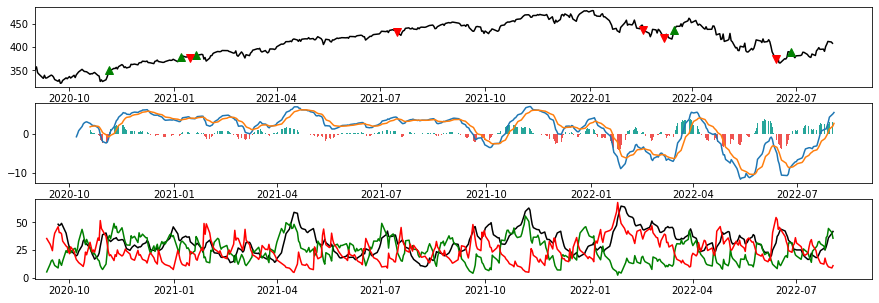

In [57]:
test = Agent(DATA)
test.execute()
test.plot(False)
test.evaluate()

In [58]:
print(test.transaction_data)

                             open      high     low   close     volume  \
timestamp                                                                
2020-11-05 05:00:00+00:00  349.28  352.1900  348.86  350.24   82039783   
2021-01-07 05:00:00+00:00  376.18  379.9000  375.91  379.10   68801420   
2021-01-15 05:00:00+00:00  376.71  377.5800  373.70  375.70  109181262   
2021-01-20 05:00:00+00:00  381.10  384.7900  380.69  383.89   62836143   
2021-07-16 04:00:00+00:00  436.04  436.0600  430.92  431.34   79436975   
2022-02-17 05:00:00+00:00  443.18  446.5652  436.42  437.08   96702624   
2022-03-07 05:00:00+00:00  431.58  432.3018  419.36  419.43  131262026   
2022-03-16 04:00:00+00:00  429.94  435.6800  424.80  435.55  138130298   
2022-06-13 04:00:00+00:00  380.00  381.8100  373.30  375.00  169359983   
2022-06-27 04:00:00+00:00  391.12  391.3600  387.44  388.59   65967268   

                           trade_count        vwap  MACD_12_26_9  \
timestamp                                  